# Machine Learning Engineer Nanodegree

## Capstone Project: Write an Algorithm for Identifying T-Shirt's Graphic Type

### Why We're Here 

In this notebook, I will take steps towards developing an algorithm that could be used as part of a mobile or web app.  My code will accept any user-supplied image as input.  If a t-shirt is detected in the image, it will provide an estimate the graphic type on the t-shirt.

### The Road Ahead

The notebook is segregated into steps. Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect T-Shirts
* [Step 2](#step2): Create a CNN to Classify Graphic Types on T-Shirts (from Scratch)
* [Step 3](#step3): Use the CNN to Classify Graphic Types on T-Shirts
* [Step 4](#step4): Create a CNN to Graphic Types on T-Shirts (using Transfer Learning)
* [Step 5](#step5): Write an Algorithm
* [Step 6](#step6): Test the Algorithm

---
<a id='step0'></a>
## Step 0: Import T-Shirt Datasets

In the code cell below, I've imported a dataset of t-shirt images, and populated a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `graphic_types` - list of string-valued graphic type names for translating labels


In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    tshirt_files = np.array(data['filenames'])
    tshirt_targets = np_utils.to_categorical(np.array(data['target']), 24)
    return tshirt_files, tshirt_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('tshirtImages/train')
valid_files, valid_targets = load_dataset('tshirtImages/valid')
test_files, test_targets = load_dataset('tshirtImages/test')

# load list of graphic types of tshirts
graphic_types = [item[20:-1] for item in sorted(glob("tshirtImages/train/*/"))]

# print statistics about the dataset
print("There are %d total tshirts' graphic categories." % len(graphic_types))
print('There are %s total tshirt images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training tshirt images.' % len(train_files))
print('There are %d validation tshirt images.' % len(valid_files))
print('There are %d test tshirt images.'% len(test_files))

Using TensorFlow backend.


There are 24 total tshirts' graphic categories.
There are 11815 total tshirt images.

There are 6675 training tshirt images.
There are 1580 validation tshirt images.
There are 3560 test tshirt images.


---
<a id='step1'></a>
## Step 1: Detect T-Shirt

In this section, I use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect t-shirts in images. The first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks. ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [2]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN. The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels. Next, the image is converted to an array, which is then resized to a 4D tensor. In this case, since I'm working with color images, each image has three channels. Likewise, since I'm processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths. It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in the dataset!

In [3]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing. First, the RGB image is converted to BGR by reordering the channels. All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image. This is implemented in the imported function `preprocess_input`.

Now that I have a way to format a image for supplying to ResNet-50, I'm now ready to use the model to extract the predictions. This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category. This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, I obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [4]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a T-Shirt Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), one will notice that the category corresponding to t-shirt corresponds to dictionary key 610. Thus, in order to check to see if an image is predicted to contain a t-shirt by the pre-trained ResNet-50 model, I need only check if the `ResNet50_predict_labels` function above returns a value equal to 610.

Using these ideas to complete the `tshirt_detector` function below, which returns `True` if a t-shirt is detected in an image (and `False` if not).

In [5]:
### returns "True" if a t-shirt is detected in the image stored at img_path
def tshirt_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return (prediction == 610) 

---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Graphic Types on T-Shirts (from Scratch)

Now that I have a function for detecting t-shirts in images, I need a way to predict graphic type from images. In this step, I will create a CNN that classifies graphic types of t-shirts.

More parameters means longer training, which means one is more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; so that one can extrapolate this estimate to figure out how long it will take for the algorithm to train. 

I would like to mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 24 times, which corresponds to an accuracy of 4.17%, hence the task of assigning graphic types to t-shirts from images is considered exceptionally challenging.  ;-)

### Pre-process the Data

I rescale the images by dividing every pixel in every image by 255.

In [6]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 3560/3560 [02:55<00:00, 20.24it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify graphic type of a t-shirt.

In [7]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(24, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)        0         
__________

### Compile the Model

In [8]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Using model checkpointing to save the model that attains the best validation loss.


In [9]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=5, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6675 samples, validate on 1580 samples
Epoch 1/5
6675/6675 [==============================] - 304s - loss: 11.0400 - acc: 0.3127 - val_loss: 12.9455 - val_acc: 0.1968
Epoch 2/5
6675/6675 [==============================] - 299s - loss: 11.0545 - acc: 0.3142 - val_loss: 12.9455 - val_acc: 0.1968
Epoch 3/5
6675/6675 [==============================] - 294s - loss: 11.0545 - acc: 0.3142 - val_loss: 12.9455 - val_acc: 0.1968
Epoch 4/5
6675/6675 [==============================] - 2903s - loss: 11.0545 - acc: 0.3142 - val_loss: 12.9455 - val_acc: 0.1968
Epoch 5/5
6675/6675 [==============================] - 305s - loss: 11.0545 - acc: 0.3142 - val_loss: 12.9455 - val_acc: 0.1968


### Load the Model with the Best Validation Loss

In [10]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Trying out the model on the test dataset of t-shirt images.  Ensuring that your test accuracy is greater than 5%.

In [11]:
# get index of predicted t-shirt graphic type for each image in test set
tshirt_graphic_type_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(tshirt_graphic_type_predictions)==np.argmax(test_targets, axis=1))/len(tshirt_graphic_type_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 18.9045%


---
<a id='step3'></a>
## Step 3: Use a CNN to Classify Graphic Types on T-Shirts

To reduce training time without sacrificing accuracy, I will use transfer learning to train my CNN.

### Obtain Bottleneck Features

In [12]:
bottleneck_features = np.load('bottleneck_features/TShirtVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model. I only add a global average pooling layer and a fully connected layer, where the latter contains one node for each graphic type category and is equipped with a softmax.


In [13]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(24, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 24)                12312     
Total params: 12,312.0
Trainable params: 12,312.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [14]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [15]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6675 samples, validate on 1580 samples
Epoch 1/20
6675/6675 [==============================] - 2s - loss: 2.2794 - acc: 0.3071 - val_loss: 3.7259 - val_acc: 0.1677
Epoch 2/20
6675/6675 [==============================] - 0s - loss: 2.2446 - acc: 0.3121 - val_loss: 3.5869 - val_acc: 0.1937
Epoch 3/20
6675/6675 [==============================] - 0s - loss: 2.2375 - acc: 0.3140 - val_loss: 3.6742 - val_acc: 0.1968
Epoch 4/20
6675/6675 [==============================] - 0s - loss: 2.2285 - acc: 0.3134 - val_loss: 3.5963 - val_acc: 0.1968
Epoch 5/20
6675/6675 [==============================] - 0s - loss: 2.2165 - acc: 0.3164 - val_loss: 3.7054 - val_acc: 0.1968
Epoch 6/20
6675/6675 [==============================] - 0s - loss: 2.2154 - acc: 0.3154 - val_loss: 3.7229 - val_acc: 0.1854
Epoch 7/20
6675/6675 [==============================] - 0s - loss: 2.2104 - acc: 0.3124 - val_loss: 3.6445 - val_acc: 0.1924
Epoch 8/20
6675/6675 [==============================] - 0s - loss: 2.2041 - a

### Load the Model with the Best Validation Loss

In [16]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, I can use the CNN to test how well it identifies graphic type within our test dataset of t-shirt images. I've printed the test accuracy below.

In [28]:
# get index of predicted t-shirt graphic type for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 54.0842%


### Predict T-Shirt Graphic Type with the Model

In [18]:
from extract_bottleneck_features import *

def VGG16_predict_graphic_type(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return graphic type of t-shirt that is predicted by the model
    return graphic_types[np.argmax(predicted_vector)]

---
<a id='step4'></a>
## Step 4: Create a CNN to Graphic Types on T-Shirts (using Transfer Learning)

I will now use transfer learning to create a CNN that can identify graphic type of a t-shirt from images. The CNN shall attain at least 60% accuracy on the test set.

In Step 3, I used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, I'll use the bottleneck features from a different pre-trained model.
The files are encoded as such:

    TShirt{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/TShirt{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [19]:
bottleneck_features = np.load('bottleneck_features/TShirtResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify graphic type of a t-shirt.

In [20]:
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(24, activation='softmax'))

Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                49176     
Total params: 49,176.0
Trainable params: 49,176.0
Non-trainable params: 0.0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [21]:
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Use model checkpointing to save the model that attains the best validation loss.  


In [22]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.ResNet50.hdf5', verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, train_targets, validation_data=(valid_Resnet50, valid_targets), 
                   epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6675 samples, validate on 1580 samples
Epoch 1/20
6675/6675 [==============================] - 1s - loss: 2.2949 - acc: 0.2903 - val_loss: 3.6025 - val_acc: 0.1968
Epoch 2/20
6675/6675 [==============================] - 0s - loss: 2.2732 - acc: 0.3004 - val_loss: 3.2489 - val_acc: 0.1968
Epoch 3/20
6675/6675 [==============================] - 0s - loss: 2.2718 - acc: 0.3019 - val_loss: 3.6380 - val_acc: 0.1968
Epoch 4/20
6675/6675 [==============================] - 0s - loss: 2.2650 - acc: 0.3068 - val_loss: 3.5203 - val_acc: 0.1962
Epoch 5/20
6675/6675 [==============================] - 0s - loss: 2.2638 - acc: 0.3022 - val_loss: 3.5894 - val_acc: 0.1968
Epoch 6/20
6675/6675 [==============================] - 0s - loss: 2.2620 - acc: 0.3023 - val_loss: 3.6152 - val_acc: 0.1690
Epoch 7/20
6675/6675 [==============================] - 0s - loss: 2.2592 - acc: 0.3071 - val_loss: 3.6596 - val_acc: 0.1962
Epoch 8/20
6675/6675 [==============================] - 0s - loss: 2.2568 - a

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [23]:
Resnet50_model.load_weights('saved_models/weights.best.ResNet50.hdf5')

### (IMPLEMENTATION) Test the Model

Trying out the model on the test dataset of t-shirt images. Ensuring that the test accuracy is greater than 60%.

In [29]:
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1)) / len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 84.7472%


### (IMPLEMENTATION) Predict Graphic Type of a T-Shirt with the Model

A function that takes an image path as input and returns the graphic type of the t-shirt that is predicted by the model.  

Similar to the analogous function in Step 4, the function has three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector. Note that the argmax of this prediction vector gives the index of the predicted graphic type of the t-shirt.
3. Using the `graphic_types` array defined in Step 0 of this notebook to return the corresponding graphic type.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell. To obtain the bottleneck features corresponding to the chosen CNN architecture, the function call is

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [25]:
### Function that takes a path to an image as input
### and returns the graphic type of a t-shirt that is predicted by the model.
def Resnet50_tshirt_graphic_type(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    
    # t-shirt graphic type index
    graphic_type_index = np.argmax(predicted_vector)
    
    # return t-shirt graphic type that is predicted by the model
    return graphic_types[graphic_type_index]

---
<a id='step5'></a>
## Step 5: Write an Algorithm

An algorithm that accepts a file path to an image and first determines whether the image contains a t-shirt or not.  Then,
- if a __t-shirt__ is detected in the image, return the predicted graphic type.
- if __not__ is detected in the image, provide output that indicates an error.


### (IMPLEMENTATION) Algorithm

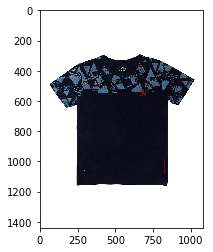

That's a t-shirt. Graphic type: 2.Solid


In [26]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from extract_bottleneck_features import *

def Resnet50_tshirt_graphic_type_detector(img_path):
    graphic_type = Resnet50_tshirt_graphic_type(img_path) 
    
    # Display the image
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    
    # Detect what it is
    if tshirt_detector(img_path):
        print("That's a t-shirt. Graphic type: " + str(graphic_type))
    else:
        print("I'm sorry, Dave. I'm afraid I can't do that!")

Resnet50_tshirt_graphic_type_detector(train_files[0])

---
<a id='step6'></a>
## Step 6: Test the Algorithm

In this section, I will take the algorithm for a spin!  What kind of graphic type does the algorithm think that __my t-shirt__ has?  Does it predict my t-shirt's graphic type accurately? If I have a shirt, does it mistakenly think that my shirt is a t-shirt?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!


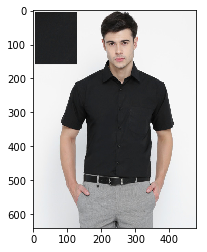

I'm sorry, Dave. I'm afraid I can't do that!


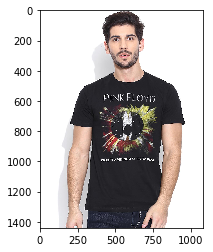

That's a t-shirt. Graphic type: 2.Solid


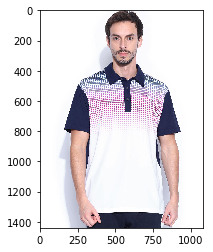

I'm sorry, Dave. I'm afraid I can't do that!


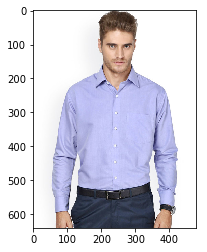

I'm sorry, Dave. I'm afraid I can't do that!


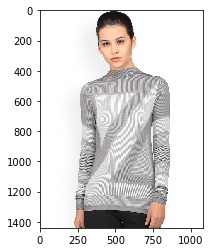

I'm sorry, Dave. I'm afraid I can't do that!


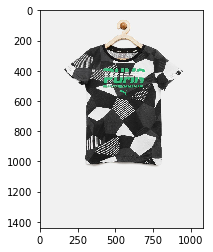

I'm sorry, Dave. I'm afraid I can't do that!


In [27]:
sample_images = np.array(glob("sampleImages/*"))
for path in sample_images:
    Resnet50_tshirt_graphic_type_detector(path)